Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257


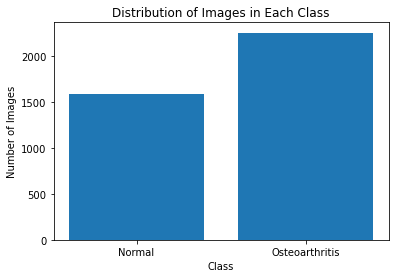

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML3/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML3/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Create a histogram to visualize the distribution of images in each class
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


2024-03-22 12:05:59.506628: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 12:05:59.725770: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 12:05:59.725804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 12:05:59.758626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 12:05:59.827550: I tensorflow/core/platform/cpu_feature_guar

Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257
Number of images in Normal class after augmentation: 2257


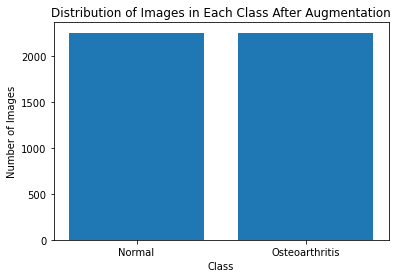

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define a function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML3/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML3/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Check if data augmentation is needed
if len(normal_images) < len(osteoarthritis_images):
    # Calculate the number of additional images needed
    num_additional_images = len(osteoarthritis_images) - len(normal_images)

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Choose random indices from the "Normal" class for augmentation
    sampled_indices = np.random.randint(0, len(normal_images), size=num_additional_images)

    # Perform data augmentation and append augmented images to the "Normal" class
    for index in sampled_indices:
        img = normal_images[index]
        img = img.reshape((1,) + img.shape)  # Reshape for flow() function
        for batch in datagen.flow(img, batch_size=1):
            normal_images.append(batch[0])  # Append augmented images
            break  # Exit the loop after one iteration of data augmentation

    # Display the number of images in the "Normal" class after augmentation
    print("Number of images in Normal class after augmentation:", len(normal_images))

# Create a histogram to visualize the distribution of images in each class after augmentation
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [3]:
import random

# Set a seed for reproducibility
random.seed(42)

# Randomly select 1000 images from each class
selected_normal_images = random.sample(normal_images, 1000)
selected_osteoarthritis_images = random.sample(osteoarthritis_images, 1000)

# Combine selected images from both classes
selected_images = selected_normal_images + selected_osteoarthritis_images
labels = [0] * 1000 + [1] * 1000  # Assign labels (0 for Normal, 1 for Osteoarthritis)

# Split the selected images and labels into train and test sets (70:30 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_images, labels, test_size=0.3, random_state=42)

# Split the train set into train and validation sets (80:20 ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the sizes of train, test, and validation sets
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))
print("X_validation size:", len(X_val))


X_train size: 1120
X_test size: 600
X_validation size: 280


# ResNet

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)



# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [6]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 28s 789ms/step - loss: 0.6342 - accuracy: 0.6929 - val_loss: 0.4518 - val_accuracy: 0.7893
Epoch 2/50
35/35 [==============================] - 28s 804ms/step - loss: 0.4003 - accuracy: 0.8125 - val_loss: 0.4716 - val_accuracy: 0.7643
Epoch 3/50
35/35 [==============================] - 28s 808ms/step - loss: 0.3360 - accuracy: 0.8518 - val_loss: 0.3869 - val_accuracy: 0.8214
Epoch 4/50
35/35 [==============================] - 30s 856ms/step - loss: 0.2914 - accuracy: 0.8821 - val_loss: 0.4606 - val_accuracy: 0.7929
Epoch 5/50
35/35 [==============================] - 29s 840ms/step - loss: 0.2760 - accuracy: 0.8848 - val_loss: 0.4227 - val_accuracy: 0.8179
Epoch 6/50
35/35 [==============================] - 29s 830ms/step - loss: 0.2695 - accuracy: 0.8795 - val_loss: 0.4097 - val_accuracy: 0.8143
Epoch 7/50
35/35 [==============================] - 29s 832ms/step - loss: 0.2154 - accuracy: 0.9170 - val_loss: 0.3771 - val_accuracy: 0.8429

19/19 [==============================] - 13s 650ms/step
Inference Time: 12.890437364578247 seconds
9/9 [==============================] - 6s 638ms/step - loss: 0.3536 - accuracy: 0.8714
Validation Loss: 0.35363373160362244
Validation Accuracy: 0.8714285492897034
19/19 [==============================] - 12s 651ms/step - loss: 0.3682 - accuracy: 0.8633
Test Loss: 0.368233323097229
Test Accuracy: 0.8633333444595337
ROC AUC Score: 0.931496955420241
Confusion Matrix:
[[257  45]
 [ 37 261]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       302
           1       0.85      0.88      0.86       298

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



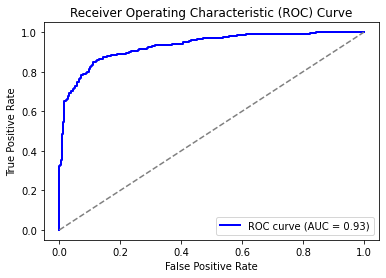

Metrics saved successfully


In [7]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import pandas as pd

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 29s 836ms/step - loss: 0.1131 - accuracy: 0.9714 - val_loss: 0.3624 - val_accuracy: 0.8571
Epoch 2/100
35/35 [==============================] - 29s 833ms/step - loss: 0.1184 - accuracy: 0.9634 - val_loss: 0.3675 - val_accuracy: 0.8714
Epoch 3/100
35/35 [==============================] - 29s 833ms/step - loss: 0.1092 - accuracy: 0.9652 - val_loss: 0.4970 - val_accuracy: 0.8321
Epoch 4/100
35/35 [==============================] - 29s 833ms/step - loss: 0.1158 - accuracy: 0.9554 - val_loss: 0.4117 - val_accuracy: 0.8500
Epoch 5/100
35/35 [==============================] - 29s 831ms/step - loss: 0.1172 - accuracy: 0.9554 - val_loss: 0.3906 - val_accuracy: 0.8500
Epoch 6/100
35/35 [==============================] - 29s 832ms/step - loss: 0.0818 - accuracy: 0.9759 - val_loss: 0.3738 - val_accuracy: 0.8571
Training Time: 174.2843954563141 seconds


19/19 [==============================] - 12s 653ms/step
Inference Time: 12.630220651626587 seconds
9/9 [==============================] - 6s 640ms/step - loss: 0.3624 - accuracy: 0.8571
Validation Loss: 0.3624386489391327
Validation Accuracy: 0.8571428656578064
19/19 [==============================] - 12s 651ms/step - loss: 0.3678 - accuracy: 0.8583
Test Loss: 0.36783701181411743
Test Accuracy: 0.8583333492279053
ROC AUC Score: 0.9318969731988089
Confusion Matrix:
[[255  47]
 [ 38 260]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       302
           1       0.85      0.87      0.86       298

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



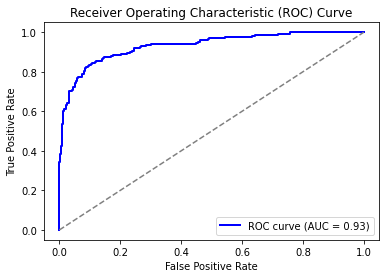

Metrics saved successfully


In [9]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [10]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 29s 837ms/step - loss: 0.1176 - accuracy: 0.9625 - val_loss: 0.3770 - val_accuracy: 0.8571
Epoch 2/150
35/35 [==============================] - 29s 831ms/step - loss: 0.1004 - accuracy: 0.9714 - val_loss: 0.3639 - val_accuracy: 0.8643
Epoch 3/150
35/35 [==============================] - 29s 832ms/step - loss: 0.1101 - accuracy: 0.9580 - val_loss: 0.4198 - val_accuracy: 0.8393
Epoch 4/150
35/35 [==============================] - 29s 832ms/step - loss: 0.0922 - accuracy: 0.9714 - val_loss: 0.4025 - val_accuracy: 0.8500
Epoch 5/150
35/35 [==============================] - 29s 830ms/step - loss: 0.0706 - accuracy: 0.9786 - val_loss: 0.3967 - val_accuracy: 0.8714
Epoch 6/150
35/35 [==============================] - 29s 832ms/step - loss: 0.0655 - accuracy: 0.9839 - val_loss: 0.4041 - val_accuracy: 0.8429
Epoch 7/150
35/35 [==============================] - 29s 832ms/step - loss: 0.0480 - accuracy: 0.9946 - val_loss: 0.3837 - val_accuracy:

19/19 [==============================] - 12s 652ms/step
Inference Time: 12.602506875991821 seconds
9/9 [==============================] - 6s 642ms/step - loss: 0.3639 - accuracy: 0.8643
Validation Loss: 0.3639390170574188
Validation Accuracy: 0.8642857074737549
19/19 [==============================] - 12s 652ms/step - loss: 0.3829 - accuracy: 0.8700
Test Loss: 0.38287171721458435
Test Accuracy: 0.8700000047683716
ROC AUC Score: 0.9314302857904796
Confusion Matrix:
[[273  29]
 [ 49 249]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       302
           1       0.90      0.84      0.86       298

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600



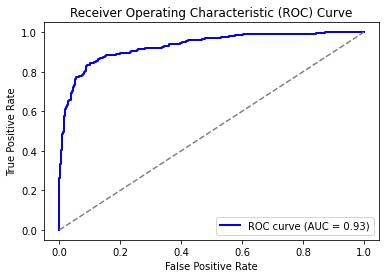

Metrics saved successfully


In [11]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [12]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 29s 836ms/step - loss: 0.0866 - accuracy: 0.9750 - val_loss: 0.3543 - val_accuracy: 0.8643
Epoch 2/200
35/35 [==============================] - 29s 831ms/step - loss: 0.0793 - accuracy: 0.9795 - val_loss: 0.3763 - val_accuracy: 0.8643
Epoch 3/200
35/35 [==============================] - 29s 831ms/step - loss: 0.0697 - accuracy: 0.9830 - val_loss: 0.3785 - val_accuracy: 0.8500
Epoch 4/200
35/35 [==============================] - 29s 832ms/step - loss: 0.0599 - accuracy: 0.9902 - val_loss: 0.4314 - val_accuracy: 0.8500
Epoch 5/200
35/35 [==============================] - 29s 831ms/step - loss: 0.0472 - accuracy: 0.9920 - val_loss: 0.3932 - val_accuracy: 0.8750
Epoch 6/200
35/35 [==============================] - 29s 833ms/step - loss: 0.0565 - accuracy: 0.9875 - val_loss: 0.4135 - val_accuracy: 0.8607
Training Time: 174.18332695960999 seconds


19/19 [==============================] - 12s 651ms/step
Inference Time: 12.586300373077393 seconds
9/9 [==============================] - 6s 641ms/step - loss: 0.3543 - accuracy: 0.8643
Validation Loss: 0.35430943965911865
Validation Accuracy: 0.8642857074737549
19/19 [==============================] - 12s 651ms/step - loss: 0.3867 - accuracy: 0.8700
Test Loss: 0.3867094814777374
Test Accuracy: 0.8700000047683716
ROC AUC Score: 0.931096937641673
Confusion Matrix:
[[268  34]
 [ 44 254]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       302
           1       0.88      0.85      0.87       298

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600



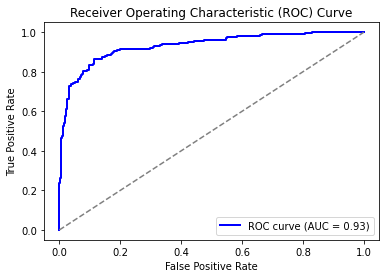

Metrics saved successfully


In [13]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Dense+Dropout

In [6]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout

# Load ResNet-50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(128, activation='relu')(x)  # Additional dense layer
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [15]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 30s 847ms/step - loss: 0.6539 - accuracy: 0.6652 - val_loss: 0.4591 - val_accuracy: 0.7679
Epoch 2/50
35/35 [==============================] - 29s 834ms/step - loss: 0.4957 - accuracy: 0.7589 - val_loss: 0.4425 - val_accuracy: 0.7714
Epoch 3/50
35/35 [==============================] - 29s 834ms/step - loss: 0.4515 - accuracy: 0.7812 - val_loss: 0.4250 - val_accuracy: 0.8107
Epoch 4/50
35/35 [==============================] - 29s 833ms/step - loss: 0.4066 - accuracy: 0.8179 - val_loss: 0.4307 - val_accuracy: 0.8143
Epoch 5/50
35/35 [==============================] - 29s 834ms/step - loss: 0.3708 - accuracy: 0.8277 - val_loss: 0.3867 - val_accuracy: 0.8321
Epoch 6/50
35/35 [==============================] - 29s 833ms/step - loss: 0.3649 - accuracy: 0.8402 - val_loss: 0.3942 - val_accuracy: 0.8286
Epoch 7/50
35/35 [==============================] - 29s 834ms/step - loss: 0.3615 - accuracy: 0.8366 - val_loss: 0.3708 - val_accuracy: 0.8429

19/19 [==============================] - 13s 651ms/step
Inference Time: 12.901123523712158 seconds
9/9 [==============================] - 6s 639ms/step - loss: 0.3579 - accuracy: 0.8679
Validation Loss: 0.3579251766204834
Validation Accuracy: 0.8678571581840515
19/19 [==============================] - 12s 650ms/step - loss: 0.3569 - accuracy: 0.8333
Test Loss: 0.35688316822052
Test Accuracy: 0.8333333134651184
ROC AUC Score: 0.9188186141606294
Confusion Matrix:
[[256  46]
 [ 54 244]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       302
           1       0.84      0.82      0.83       298

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600



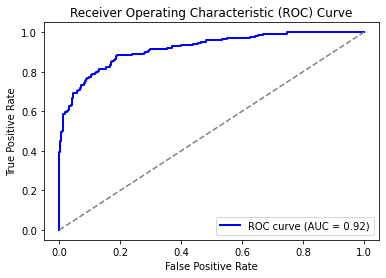

Metrics saved successfully


In [16]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [17]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 29s 838ms/step - loss: 0.2558 - accuracy: 0.8893 - val_loss: 0.4349 - val_accuracy: 0.8321
Epoch 2/100
35/35 [==============================] - 29s 833ms/step - loss: 0.2724 - accuracy: 0.8839 - val_loss: 0.3664 - val_accuracy: 0.8643
Epoch 3/100
35/35 [==============================] - 29s 833ms/step - loss: 0.2600 - accuracy: 0.8866 - val_loss: 0.3759 - val_accuracy: 0.8500
Epoch 4/100
35/35 [==============================] - 29s 834ms/step - loss: 0.2263 - accuracy: 0.9027 - val_loss: 0.3789 - val_accuracy: 0.8607
Epoch 5/100
35/35 [==============================] - 29s 832ms/step - loss: 0.2600 - accuracy: 0.8911 - val_loss: 0.5179 - val_accuracy: 0.8000
Epoch 6/100
35/35 [==============================] - 29s 832ms/step - loss: 0.2768 - accuracy: 0.8777 - val_loss: 0.3919 - val_accuracy: 0.8357
Epoch 7/100
35/35 [==============================] - 29s 834ms/step - loss: 0.2498 - accuracy: 0.8821 - val_loss: 0.3844 - val_accuracy:

19/19 [==============================] - 12s 653ms/step
Inference Time: 12.614547729492188 seconds
9/9 [==============================] - 6s 639ms/step - loss: 0.3664 - accuracy: 0.8643
Validation Loss: 0.36635303497314453
Validation Accuracy: 0.8642857074737549
19/19 [==============================] - 12s 651ms/step - loss: 0.3564 - accuracy: 0.8467
Test Loss: 0.3564208745956421
Test Accuracy: 0.846666693687439
ROC AUC Score: 0.9240410684919329
Confusion Matrix:
[[258  44]
 [ 48 250]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       302
           1       0.85      0.84      0.84       298

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



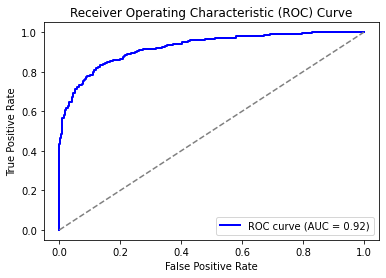

Metrics saved successfully


In [18]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [19]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 29s 837ms/step - loss: 0.2592 - accuracy: 0.8893 - val_loss: 0.3699 - val_accuracy: 0.8464
Epoch 2/150
35/35 [==============================] - 29s 834ms/step - loss: 0.2531 - accuracy: 0.8902 - val_loss: 0.3624 - val_accuracy: 0.8464
Epoch 3/150
35/35 [==============================] - 29s 834ms/step - loss: 0.2399 - accuracy: 0.9009 - val_loss: 0.3677 - val_accuracy: 0.8464
Epoch 4/150
35/35 [==============================] - 29s 834ms/step - loss: 0.2677 - accuracy: 0.8893 - val_loss: 0.4006 - val_accuracy: 0.8179
Epoch 5/150
35/35 [==============================] - 29s 833ms/step - loss: 0.2658 - accuracy: 0.8857 - val_loss: 0.4293 - val_accuracy: 0.8357
Epoch 6/150
35/35 [==============================] - 29s 833ms/step - loss: 0.2731 - accuracy: 0.8830 - val_loss: 0.3687 - val_accuracy: 0.8571
Epoch 7/150
35/35 [==============================] - 29s 834ms/step - loss: 0.2374 - accuracy: 0.9080 - val_loss: 0.3611 - val_accuracy:

19/19 [==============================] - 12s 651ms/step
Inference Time: 12.584058046340942 seconds
9/9 [==============================] - 6s 639ms/step - loss: 0.3611 - accuracy: 0.8571
Validation Loss: 0.3611454665660858
Validation Accuracy: 0.8571428656578064
19/19 [==============================] - 12s 651ms/step - loss: 0.3509 - accuracy: 0.8583
Test Loss: 0.3508765697479248
Test Accuracy: 0.8583333492279053
ROC AUC Score: 0.9295524245522022
Confusion Matrix:
[[261  41]
 [ 44 254]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       302
           1       0.86      0.85      0.86       298

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



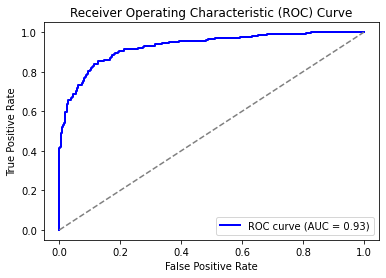

Metrics saved successfully


In [20]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 29s 794ms/step - loss: 0.6890 - accuracy: 0.6607 - val_loss: 0.7472 - val_accuracy: 0.6214
Epoch 2/200
35/35 [==============================] - 29s 822ms/step - loss: 0.5152 - accuracy: 0.7563 - val_loss: 0.4897 - val_accuracy: 0.7643
Epoch 3/200
35/35 [==============================] - 29s 832ms/step - loss: 0.4804 - accuracy: 0.7625 - val_loss: 0.4204 - val_accuracy: 0.8250
Epoch 4/200
35/35 [==============================] - 29s 831ms/step - loss: 0.3847 - accuracy: 0.8223 - val_loss: 0.3854 - val_accuracy: 0.8393
Epoch 5/200
35/35 [==============================] - 29s 834ms/step - loss: 0.3960 - accuracy: 0.8161 - val_loss: 0.3776 - val_accuracy: 0.8393
Epoch 6/200
35/35 [==============================] - 29s 832ms/step - loss: 0.3681 - accuracy: 0.8241 - val_loss: 0.3743 - val_accuracy: 0.8500
Epoch 7/200
35/35 [==============================] - 29s 832ms/step - loss: 0.3342 - accuracy: 0.8455 - val_loss: 0.3630 - val_accuracy:

19/19 [==============================] - 12s 610ms/step
Inference Time: 11.82798457145691 seconds
9/9 [==============================] - 6s 607ms/step - loss: 0.3563 - accuracy: 0.8643
Validation Loss: 0.35631701350212097
Validation Accuracy: 0.8642857074737549
19/19 [==============================] - 12s 649ms/step - loss: 0.3646 - accuracy: 0.8350
Test Loss: 0.36457541584968567
Test Accuracy: 0.8349999785423279
ROC AUC Score: 0.9151295613138362
Confusion Matrix:
[[265  37]
 [ 62 236]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       302
           1       0.86      0.79      0.83       298

    accuracy                           0.83       600
   macro avg       0.84      0.83      0.83       600
weighted avg       0.84      0.83      0.83       600



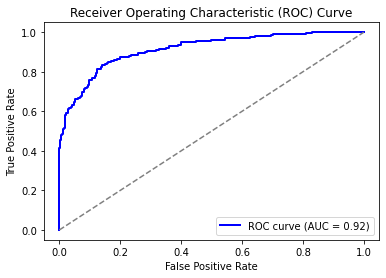

Metrics saved successfully


In [10]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

In [9]:
import pandas as pd

# ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add additional layers
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [12]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 31s 861ms/step - loss: 0.9623 - accuracy: 0.5607 - val_loss: 0.5032 - val_accuracy: 0.7536
Epoch 2/50
35/35 [==============================] - 29s 841ms/step - loss: 0.5428 - accuracy: 0.7330 - val_loss: 0.5683 - val_accuracy: 0.6393
Epoch 3/50
35/35 [==============================] - 29s 839ms/step - loss: 0.5118 - accuracy: 0.7250 - val_loss: 0.4524 - val_accuracy: 0.8036
Epoch 4/50
35/35 [==============================] - 29s 842ms/step - loss: 0.4589 - accuracy: 0.7920 - val_loss: 0.4244 - val_accuracy: 0.8143
Epoch 5/50
35/35 [==============================] - 29s 841ms/step - loss: 0.4025 - accuracy: 0.8107 - val_loss: 0.4220 - val_accuracy: 0.8036
Epoch 6/50
35/35 [==============================] - 29s 839ms/step - loss: 0.3945 - accuracy: 0.7920 - val_loss: 0.3883 - val_accuracy: 0.8464
Epoch 7/50
35/35 [==============================] - 29s 841ms/step - loss: 0.3623 - accuracy: 0.8232 - val_loss: 0.3874 - val_accuracy: 0.8000

19/19 [==============================] - 13s 658ms/step
Inference Time: 13.035283088684082 seconds
9/9 [==============================] - 6s 641ms/step - loss: 0.3380 - accuracy: 0.8429
Validation Loss: 0.33798709511756897
Validation Accuracy: 0.8428571224212646
19/19 [==============================] - 12s 653ms/step - loss: 0.3758 - accuracy: 0.8367
Test Loss: 0.37582606077194214
Test Accuracy: 0.8366666436195374
ROC AUC Score: 0.9171296502066759
Confusion Matrix:
[[258  44]
 [ 54 244]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       302
           1       0.85      0.82      0.83       298

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



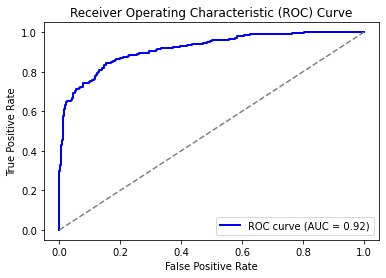

Metrics saved successfully


In [13]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [14]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 30s 855ms/step - loss: 0.2497 - accuracy: 0.8804 - val_loss: 0.3385 - val_accuracy: 0.8536
Epoch 2/100
35/35 [==============================] - 29s 839ms/step - loss: 0.2252 - accuracy: 0.8938 - val_loss: 0.3921 - val_accuracy: 0.8571
Epoch 3/100
35/35 [==============================] - 29s 839ms/step - loss: 0.2555 - accuracy: 0.8839 - val_loss: 0.3337 - val_accuracy: 0.8679
Epoch 4/100
35/35 [==============================] - 29s 839ms/step - loss: 0.2423 - accuracy: 0.8938 - val_loss: 0.4196 - val_accuracy: 0.8571
Epoch 5/100
35/35 [==============================] - 29s 839ms/step - loss: 0.2176 - accuracy: 0.8893 - val_loss: 0.3566 - val_accuracy: 0.8607
Epoch 6/100
35/35 [==============================] - 29s 839ms/step - loss: 0.2005 - accuracy: 0.9116 - val_loss: 0.3298 - val_accuracy: 0.8786
Epoch 7/100
35/35 [==============================] - 29s 840ms/step - loss: 0.1826 - accuracy: 0.9152 - val_loss: 0.3885 - val_accuracy:

19/19 [==============================] - 12s 654ms/step
Inference Time: 12.656076431274414 seconds
9/9 [==============================] - 6s 659ms/step - loss: 0.3298 - accuracy: 0.8786
Validation Loss: 0.3298465609550476
Validation Accuracy: 0.8785714507102966
19/19 [==============================] - 13s 678ms/step - loss: 0.3315 - accuracy: 0.8583
Test Loss: 0.33152419328689575
Test Accuracy: 0.8583333492279053
ROC AUC Score: 0.9313636161607183
Confusion Matrix:
[[263  39]
 [ 46 252]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       302
           1       0.87      0.85      0.86       298

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



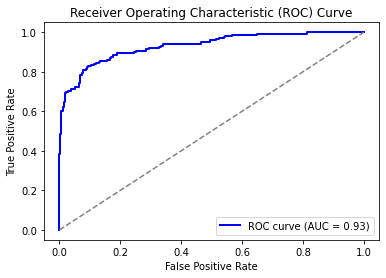

Metrics saved successfully


In [15]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [16]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 30s 861ms/step - loss: 0.1834 - accuracy: 0.9116 - val_loss: 0.3735 - val_accuracy: 0.8429
Epoch 2/150
35/35 [==============================] - 29s 839ms/step - loss: 0.1741 - accuracy: 0.9161 - val_loss: 0.3908 - val_accuracy: 0.8679
Epoch 3/150
35/35 [==============================] - 29s 838ms/step - loss: 0.1860 - accuracy: 0.9196 - val_loss: 0.4025 - val_accuracy: 0.8321
Epoch 4/150
35/35 [==============================] - 29s 839ms/step - loss: 0.1783 - accuracy: 0.9295 - val_loss: 0.4479 - val_accuracy: 0.8571
Epoch 5/150
35/35 [==============================] - 29s 846ms/step - loss: 0.1628 - accuracy: 0.9259 - val_loss: 0.3786 - val_accuracy: 0.8714
Epoch 6/150
35/35 [==============================] - 29s 840ms/step - loss: 0.1439 - accuracy: 0.9348 - val_loss: 0.4007 - val_accuracy: 0.8786
Training Time: 176.5203938484192 seconds


19/19 [==============================] - 12s 652ms/step
Inference Time: 12.606621503829956 seconds
9/9 [==============================] - 6s 641ms/step - loss: 0.3735 - accuracy: 0.8429
Validation Loss: 0.3735082149505615
Validation Accuracy: 0.8428571224212646
19/19 [==============================] - 12s 653ms/step - loss: 0.3680 - accuracy: 0.8483
Test Loss: 0.3679920434951782
Test Accuracy: 0.8483333587646484
ROC AUC Score: 0.9266300724476643
Confusion Matrix:
[[265  37]
 [ 54 244]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       302
           1       0.87      0.82      0.84       298

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



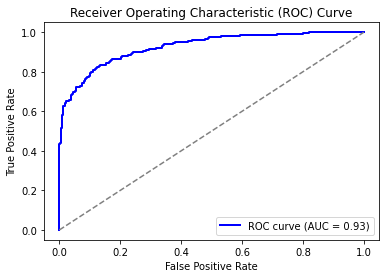

Metrics saved successfully


In [17]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [18]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 29s 847ms/step - loss: 0.1639 - accuracy: 0.9286 - val_loss: 0.3488 - val_accuracy: 0.8786
Epoch 2/200
35/35 [==============================] - 29s 839ms/step - loss: 0.2100 - accuracy: 0.8920 - val_loss: 0.3514 - val_accuracy: 0.8750
Epoch 3/200
35/35 [==============================] - 29s 840ms/step - loss: 0.1961 - accuracy: 0.9009 - val_loss: 0.4507 - val_accuracy: 0.8214
Epoch 4/200
35/35 [==============================] - 29s 840ms/step - loss: 0.1727 - accuracy: 0.9107 - val_loss: 0.4230 - val_accuracy: 0.8500
Epoch 5/200
35/35 [==============================] - 29s 839ms/step - loss: 0.1756 - accuracy: 0.9152 - val_loss: 0.4059 - val_accuracy: 0.8714
Epoch 6/200
35/35 [==============================] - 29s 841ms/step - loss: 0.1801 - accuracy: 0.9161 - val_loss: 0.6157 - val_accuracy: 0.8357
Training Time: 175.97192668914795 seconds


19/19 [==============================] - 12s 653ms/step
Inference Time: 12.631722450256348 seconds
9/9 [==============================] - 6s 640ms/step - loss: 0.3488 - accuracy: 0.8786
Validation Loss: 0.34875571727752686
Validation Accuracy: 0.8785714507102966
19/19 [==============================] - 12s 653ms/step - loss: 0.3812 - accuracy: 0.8550
Test Loss: 0.3812424838542938
Test Accuracy: 0.8550000190734863
ROC AUC Score: 0.9242077425663363
Confusion Matrix:
[[267  35]
 [ 52 246]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       302
           1       0.88      0.83      0.85       298

    accuracy                           0.85       600
   macro avg       0.86      0.85      0.85       600
weighted avg       0.86      0.85      0.85       600



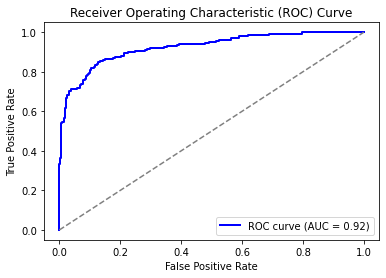

Metrics saved successfully


In [19]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+LSTM+Dense

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in resnet_base.layers:
    layer.trainable = False

# Extract features using ResNet
resnet_output = resnet_base.output
flattened_output = Flatten()(resnet_output)

# Reshape features for LSTM
reshaped_output = tf.keras.layers.Reshape((1, flattened_output.shape[1]))(flattened_output)

# LSTM layer
lstm_output = LSTM(128)(reshaped_output)

# Dense layer for classification
dense_output = Dense(64, activation='relu')(lstm_output)
predictions = Dense(1, activation='sigmoid')(dense_output)

# Create the model
model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [21]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 41s 1s/step - loss: 0.6405 - accuracy: 0.6509 - val_loss: 0.6021 - val_accuracy: 0.7250
Epoch 2/50
35/35 [==============================] - 38s 1s/step - loss: 0.5623 - accuracy: 0.7402 - val_loss: 0.5926 - val_accuracy: 0.6857
Epoch 3/50
35/35 [==============================] - 38s 1s/step - loss: 0.5045 - accuracy: 0.7759 - val_loss: 0.4946 - val_accuracy: 0.7929
Epoch 4/50
35/35 [==============================] - 38s 1s/step - loss: 0.4549 - accuracy: 0.8295 - val_loss: 0.4928 - val_accuracy: 0.7750
Epoch 5/50
35/35 [==============================] - 38s 1s/step - loss: 0.4901 - accuracy: 0.7786 - val_loss: 0.5410 - val_accuracy: 0.7429
Epoch 6/50
35/35 [==============================] - 38s 1s/step - loss: 0.4501 - accuracy: 0.7991 - val_loss: 0.4917 - val_accuracy: 0.7321
Epoch 7/50
35/35 [==============================] - 38s 1s/step - loss: 0.4054 - accuracy: 0.8232 - val_loss: 0.4637 - val_accuracy: 0.7714
Epoch 8/50
35/35 [==

19/19 [==============================] - 13s 659ms/step
Inference Time: 13.184184312820435 seconds
9/9 [==============================] - 6s 650ms/step - loss: 0.4204 - accuracy: 0.7893
Validation Loss: 0.42036202549934387
Validation Accuracy: 0.7892857193946838
19/19 [==============================] - 13s 661ms/step - loss: 0.4577 - accuracy: 0.7733
Test Loss: 0.4576500356197357
Test Accuracy: 0.7733333110809326
ROC AUC Score: 0.8691664073958844
Confusion Matrix:
[[256  46]
 [ 90 208]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       302
           1       0.82      0.70      0.75       298

    accuracy                           0.77       600
   macro avg       0.78      0.77      0.77       600
weighted avg       0.78      0.77      0.77       600



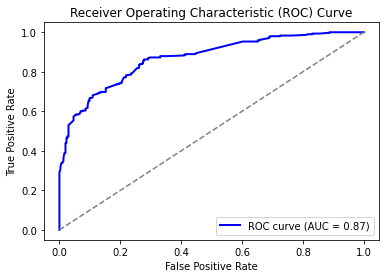

Metrics saved successfully


In [22]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [23]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 38s 1s/step - loss: 0.3252 - accuracy: 0.8607 - val_loss: 0.4305 - val_accuracy: 0.8179
Epoch 2/100
35/35 [==============================] - 38s 1s/step - loss: 0.3188 - accuracy: 0.8741 - val_loss: 0.4473 - val_accuracy: 0.8107
Epoch 3/100
35/35 [==============================] - 38s 1s/step - loss: 0.3831 - accuracy: 0.8259 - val_loss: 0.4456 - val_accuracy: 0.8143
Epoch 4/100
35/35 [==============================] - 38s 1s/step - loss: 0.3028 - accuracy: 0.8705 - val_loss: 0.4201 - val_accuracy: 0.8143
Epoch 5/100
35/35 [==============================] - 38s 1s/step - loss: 0.2793 - accuracy: 0.8750 - val_loss: 0.4463 - val_accuracy: 0.8143
Epoch 6/100
35/35 [==============================] - 38s 1s/step - loss: 0.3222 - accuracy: 0.8652 - val_loss: 0.4795 - val_accuracy: 0.7679
Epoch 7/100
35/35 [==============================] - 38s 1s/step - loss: 0.3037 - accuracy: 0.8634 - val_loss: 0.4643 - val_accuracy: 0.7929
Epoch 8/100
3

19/19 [==============================] - 13s 661ms/step
Inference Time: 12.7716383934021 seconds
9/9 [==============================] - 6s 649ms/step - loss: 0.4201 - accuracy: 0.8143
Validation Loss: 0.4200933873653412
Validation Accuracy: 0.8142856955528259
19/19 [==============================] - 13s 661ms/step - loss: 0.4669 - accuracy: 0.7983
Test Loss: 0.4668568968772888
Test Accuracy: 0.7983333468437195
ROC AUC Score: 0.8826670074225522
Confusion Matrix:
[[244  58]
 [ 63 235]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       302
           1       0.80      0.79      0.80       298

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600



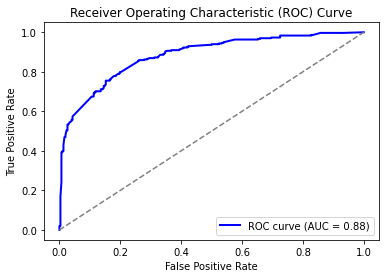

Metrics saved successfully


In [24]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [25]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 38s 1s/step - loss: 0.2837 - accuracy: 0.8804 - val_loss: 0.4482 - val_accuracy: 0.8321
Epoch 2/150
35/35 [==============================] - 38s 1s/step - loss: 0.3314 - accuracy: 0.8491 - val_loss: 0.5051 - val_accuracy: 0.7214
Epoch 3/150
35/35 [==============================] - 38s 1s/step - loss: 0.3364 - accuracy: 0.8491 - val_loss: 0.4632 - val_accuracy: 0.7786
Epoch 4/150
35/35 [==============================] - 38s 1s/step - loss: 0.3366 - accuracy: 0.8661 - val_loss: 0.4851 - val_accuracy: 0.7679
Epoch 5/150
35/35 [==============================] - 38s 1s/step - loss: 0.3074 - accuracy: 0.8741 - val_loss: 0.4368 - val_accuracy: 0.8071
Epoch 6/150
35/35 [==============================] - 38s 1s/step - loss: 0.3728 - accuracy: 0.8232 - val_loss: 0.4882 - val_accuracy: 0.7643
Epoch 7/150
35/35 [==============================] - 38s 1s/step - loss: 0.3197 - accuracy: 0.8580 - val_loss: 0.4795 - val_accuracy: 0.7821
Epoch 8/150
3

19/19 [==============================] - 13s 661ms/step
Inference Time: 12.775641202926636 seconds
9/9 [==============================] - 6s 650ms/step - loss: 0.4368 - accuracy: 0.8071
Validation Loss: 0.4368247091770172
Validation Accuracy: 0.8071428537368774
19/19 [==============================] - 13s 662ms/step - loss: 0.4616 - accuracy: 0.7983
Test Loss: 0.4616321921348572
Test Accuracy: 0.7983333468437195
ROC AUC Score: 0.8797168763056136
Confusion Matrix:
[[226  76]
 [ 45 253]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       302
           1       0.77      0.85      0.81       298

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600



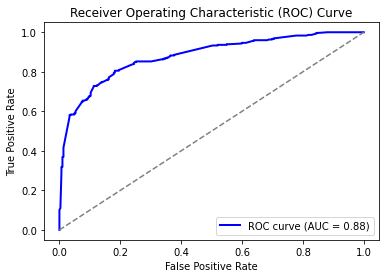

Metrics saved successfully


In [26]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [27]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 38s 1s/step - loss: 0.2720 - accuracy: 0.8839 - val_loss: 0.5088 - val_accuracy: 0.7893
Epoch 2/200
35/35 [==============================] - 38s 1s/step - loss: 0.2896 - accuracy: 0.8759 - val_loss: 0.4978 - val_accuracy: 0.7143
Epoch 3/200
35/35 [==============================] - 38s 1s/step - loss: 0.3775 - accuracy: 0.8045 - val_loss: 0.4831 - val_accuracy: 0.7143
Epoch 4/200
35/35 [==============================] - 38s 1s/step - loss: 0.3245 - accuracy: 0.8491 - val_loss: 0.4142 - val_accuracy: 0.8286
Epoch 5/200
35/35 [==============================] - 38s 1s/step - loss: 0.3155 - accuracy: 0.8777 - val_loss: 0.4445 - val_accuracy: 0.8071
Epoch 6/200
35/35 [==============================] - 38s 1s/step - loss: 0.3013 - accuracy: 0.8821 - val_loss: 0.3943 - val_accuracy: 0.8393
Epoch 7/200
35/35 [==============================] - 38s 1s/step - loss: 0.2684 - accuracy: 0.9000 - val_loss: 0.4393 - val_accuracy: 0.8071
Epoch 8/200
3

19/19 [==============================] - 13s 667ms/step
Inference Time: 12.87740421295166 seconds
9/9 [==============================] - 6s 654ms/step - loss: 0.3943 - accuracy: 0.8393
Validation Loss: 0.39427000284194946
Validation Accuracy: 0.8392857313156128
19/19 [==============================] - 13s 662ms/step - loss: 0.4134 - accuracy: 0.7950
Test Loss: 0.4134340286254883
Test Accuracy: 0.7950000166893005
ROC AUC Score: 0.8966342948575492
Confusion Matrix:
[[231  71]
 [ 52 246]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       302
           1       0.78      0.83      0.80       298

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.79       600
weighted avg       0.80      0.80      0.79       600



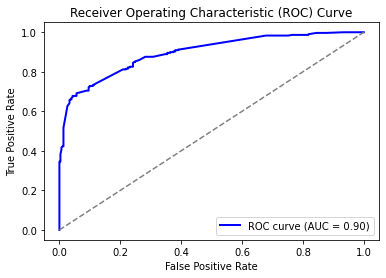

Metrics saved successfully


In [28]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")


# ResNet+GRU+Dense

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in resnet_base.layers:
    layer.trainable = False

# Extract features using ResNet
resnet_output = resnet_base.output
flattened_output = Flatten()(resnet_output)

# Reshape features for GRU
reshaped_output = tf.keras.layers.Reshape((1, flattened_output.shape[1]))(flattened_output)

# GRU layer
gru_output = GRU(128)(reshaped_output)

# Dense layers for classification
dense_output = Dense(64, activation='relu')(gru_output)
predictions = Dense(1, activation='sigmoid')(dense_output)

# Create the model
model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 37s 1s/step - loss: 0.6663 - accuracy: 0.6196 - val_loss: 0.6088 - val_accuracy: 0.7571
Epoch 2/50
35/35 [==============================] - 36s 1s/step - loss: 0.5688 - accuracy: 0.7214 - val_loss: 0.5752 - val_accuracy: 0.7464
Epoch 3/50
35/35 [==============================] - 36s 1s/step - loss: 0.5152 - accuracy: 0.7536 - val_loss: 0.5366 - val_accuracy: 0.7000
Epoch 4/50
35/35 [==============================] - 36s 1s/step - loss: 0.5266 - accuracy: 0.7223 - val_loss: 0.5817 - val_accuracy: 0.6286
Epoch 5/50
35/35 [==============================] - 36s 1s/step - loss: 0.5169 - accuracy: 0.7366 - val_loss: 0.5271 - val_accuracy: 0.7214
Epoch 6/50
35/35 [==============================] - 36s 1s/step - loss: 0.4592 - accuracy: 0.8188 - val_loss: 0.4852 - val_accuracy: 0.7679
Epoch 7/50
35/35 [==============================] - 36s 1s/step - loss: 0.4290 - accuracy: 0.8098 - val_loss: 0.4651 - val_accuracy: 0.7893
Epoch 8/50
35/35 [==

19/19 [==============================] - 13s 656ms/step
Inference Time: 13.219411611557007 seconds
9/9 [==============================] - 6s 644ms/step - loss: 0.4332 - accuracy: 0.8071
Validation Loss: 0.43316787481307983
Validation Accuracy: 0.8071428537368774
19/19 [==============================] - 13s 656ms/step - loss: 0.4395 - accuracy: 0.7967
Test Loss: 0.4394843578338623
Test Accuracy: 0.79666668176651
ROC AUC Score: 0.8824114405084671
Confusion Matrix:
[[265  37]
 [ 85 213]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.81       302
           1       0.85      0.71      0.78       298

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600



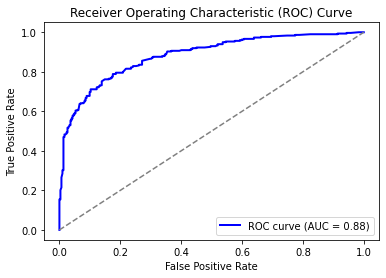

Metrics saved successfully


In [8]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score,balanced_accuracy_score,matthews_corrcoef,cohen_kappa_score
import pandas as pd
# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [9]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 36s 1s/step - loss: 0.3118 - accuracy: 0.8625 - val_loss: 0.4047 - val_accuracy: 0.8286
Epoch 2/100
35/35 [==============================] - 36s 1s/step - loss: 0.3033 - accuracy: 0.8687 - val_loss: 0.4121 - val_accuracy: 0.8429
Epoch 3/100
35/35 [==============================] - 36s 1s/step - loss: 0.3061 - accuracy: 0.8679 - val_loss: 0.4496 - val_accuracy: 0.7964
Epoch 4/100
35/35 [==============================] - 36s 1s/step - loss: 0.3065 - accuracy: 0.8714 - val_loss: 0.4134 - val_accuracy: 0.8107
Epoch 5/100
35/35 [==============================] - 36s 1s/step - loss: 0.2874 - accuracy: 0.8830 - val_loss: 0.4001 - val_accuracy: 0.8179
Epoch 6/100
35/35 [==============================] - 36s 1s/step - loss: 0.3156 - accuracy: 0.8607 - val_loss: 0.4357 - val_accuracy: 0.7893
Epoch 7/100
35/35 [==============================] - 36s 1s/step - loss: 0.3136 - accuracy: 0.8634 - val_loss: 0.4662 - val_accuracy: 0.8000
Epoch 8/100
3

19/19 [==============================] - 12s 655ms/step
Inference Time: 12.668626070022583 seconds
9/9 [==============================] - 6s 646ms/step - loss: 0.4001 - accuracy: 0.8179
Validation Loss: 0.40012282133102417
Validation Accuracy: 0.8178571462631226
19/19 [==============================] - 13s 658ms/step - loss: 0.4417 - accuracy: 0.7833
Test Loss: 0.4417259693145752
Test Accuracy: 0.7833333611488342
ROC AUC Score: 0.8767056313613939
Confusion Matrix:
[[246  56]
 [ 74 224]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       302
           1       0.80      0.75      0.78       298

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600



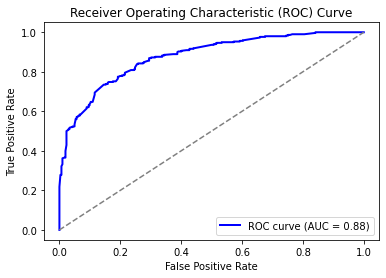

Metrics saved successfully


In [10]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [11]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 36s 1s/step - loss: 0.3211 - accuracy: 0.8598 - val_loss: 0.4616 - val_accuracy: 0.7857
Epoch 2/150
35/35 [==============================] - 36s 1s/step - loss: 0.3457 - accuracy: 0.8330 - val_loss: 0.3983 - val_accuracy: 0.8321
Epoch 3/150
35/35 [==============================] - 36s 1s/step - loss: 0.3143 - accuracy: 0.8687 - val_loss: 0.4511 - val_accuracy: 0.8107
Epoch 4/150
35/35 [==============================] - 36s 1s/step - loss: 0.3163 - accuracy: 0.8634 - val_loss: 0.4161 - val_accuracy: 0.8071
Epoch 5/150
35/35 [==============================] - 36s 1s/step - loss: 0.2441 - accuracy: 0.8964 - val_loss: 0.4585 - val_accuracy: 0.8143
Epoch 6/150
35/35 [==============================] - 36s 1s/step - loss: 0.2286 - accuracy: 0.9161 - val_loss: 0.4418 - val_accuracy: 0.8429
Epoch 7/150
35/35 [==============================] - 36s 1s/step - loss: 0.2806 - accuracy: 0.8848 - val_loss: 0.4755 - val_accuracy: 0.7821
Training Time

19/19 [==============================] - 13s 657ms/step
Inference Time: 12.697407722473145 seconds
9/9 [==============================] - 6s 646ms/step - loss: 0.3983 - accuracy: 0.8321
Validation Loss: 0.3983185887336731
Validation Accuracy: 0.8321428298950195
19/19 [==============================] - 13s 657ms/step - loss: 0.3865 - accuracy: 0.8233
Test Loss: 0.38654372096061707
Test Accuracy: 0.8233333230018616
ROC AUC Score: 0.8994010844926441
Confusion Matrix:
[[262  40]
 [ 66 232]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       302
           1       0.85      0.78      0.81       298

    accuracy                           0.82       600
   macro avg       0.83      0.82      0.82       600
weighted avg       0.83      0.82      0.82       600



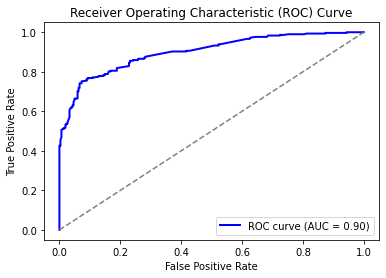

Metrics saved successfully


In [12]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
     'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [13]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 36s 1s/step - loss: 0.2964 - accuracy: 0.8830 - val_loss: 0.4147 - val_accuracy: 0.8286
Epoch 2/200
35/35 [==============================] - 36s 1s/step - loss: 0.3412 - accuracy: 0.8464 - val_loss: 0.5007 - val_accuracy: 0.7357
Epoch 3/200
35/35 [==============================] - 36s 1s/step - loss: 0.3800 - accuracy: 0.8313 - val_loss: 0.4525 - val_accuracy: 0.8107
Epoch 4/200
35/35 [==============================] - 36s 1s/step - loss: 0.3698 - accuracy: 0.8179 - val_loss: 0.4865 - val_accuracy: 0.7679
Epoch 5/200
35/35 [==============================] - 36s 1s/step - loss: 0.3461 - accuracy: 0.8438 - val_loss: 0.4699 - val_accuracy: 0.7607
Epoch 6/200
35/35 [==============================] - 36s 1s/step - loss: 0.3189 - accuracy: 0.8696 - val_loss: 0.5017 - val_accuracy: 0.7821
Training Time: 215.85811829566956 seconds


19/19 [==============================] - 13s 683ms/step
Inference Time: 13.165258407592773 seconds
9/9 [==============================] - 6s 646ms/step - loss: 0.4147 - accuracy: 0.8286
Validation Loss: 0.4146885871887207
Validation Accuracy: 0.8285714387893677
19/19 [==============================] - 13s 658ms/step - loss: 0.3983 - accuracy: 0.8317
Test Loss: 0.398258239030838
Test Accuracy: 0.8316666483879089
ROC AUC Score: 0.8983621494288634
Confusion Matrix:
[[260  42]
 [ 59 239]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       302
           1       0.85      0.80      0.83       298

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600



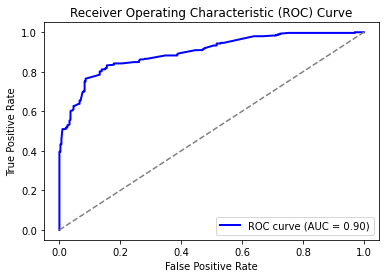

Metrics saved successfully


In [14]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Attention Mechanism+Dense

In [15]:
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, Multiply, Lambda
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
import cv2
import time
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import pandas as pd

# Start time
start_time = time.time()

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.expand_dims(X_train_resized, axis=-1)  # Add channel dimension
X_train_resized = np.repeat(X_train_resized, 3, axis=-1)  # Repeat the channel dimension to match the expected input shape of ResNet50

# Example: Assuming X_test is another dataset
X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.expand_dims(X_test_resized, axis=-1)
X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add attention mechanism
x = GlobalAveragePooling2D()(base_model.output)
x = Reshape((1, -1))(x)  # Reshape to 3D tensor for attention mechanism
attention_probs = Dense(np.prod(x.shape[2:]), activation='softmax', name='attention_probs')(x)
attention_mul = Multiply()([x, attention_probs])
attention_mul = Lambda(lambda x: K.sum(x, axis=1))(attention_mul)  # Sum along the time axis

# Add dense layers for classification
output = Dense(1, activation='sigmoid')(attention_mul)

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [16]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 31s 860ms/step - loss: 0.6602 - accuracy: 0.6687 - val_loss: 0.6181 - val_accuracy: 0.6857
Epoch 2/50
35/35 [==============================] - 29s 844ms/step - loss: 0.5671 - accuracy: 0.7848 - val_loss: 0.5336 - val_accuracy: 0.7964
Epoch 3/50
35/35 [==============================] - 29s 844ms/step - loss: 0.4993 - accuracy: 0.8179 - val_loss: 0.4825 - val_accuracy: 0.8357
Epoch 4/50
35/35 [==============================] - 29s 844ms/step - loss: 0.4445 - accuracy: 0.8554 - val_loss: 0.4565 - val_accuracy: 0.8286
Epoch 5/50
35/35 [==============================] - 29s 843ms/step - loss: 0.3933 - accuracy: 0.8786 - val_loss: 0.4314 - val_accuracy: 0.8429
Epoch 6/50
35/35 [==============================] - 29s 845ms/step - loss: 0.3635 - accuracy: 0.8813 - val_loss: 0.4125 - val_accuracy: 0.8500
Epoch 7/50
35/35 [==============================] - 30s 849ms/step - loss: 0.3369 - accuracy: 0.8929 - val_loss: 0.4027 - val_accuracy: 0.8500

19/19 [==============================] - 13s 650ms/step
Inference Time: 13.068817615509033 seconds
9/9 [==============================] - 6s 638ms/step - loss: 0.3682 - accuracy: 0.8679
Validation Loss: 0.36815571784973145
Validation Accuracy: 0.8678571581840515
19/19 [==============================] - 12s 649ms/step - loss: 0.4036 - accuracy: 0.8350
Test Loss: 0.40356945991516113
Test Accuracy: 0.8349999785423279
ROC AUC Score: 0.8973065469576426
Confusion Matrix:
[[251  51]
 [ 48 250]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       302
           1       0.83      0.84      0.83       298

    accuracy                           0.83       600
   macro avg       0.84      0.84      0.83       600
weighted avg       0.84      0.83      0.84       600



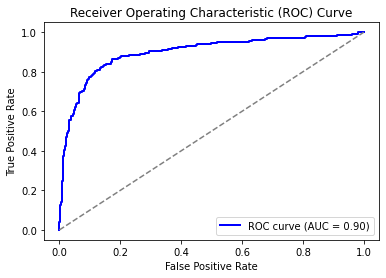

Metrics saved successfully


In [17]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [18]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 30s 848ms/step - loss: 0.2029 - accuracy: 0.9438 - val_loss: 0.3760 - val_accuracy: 0.8571
Epoch 2/100
35/35 [==============================] - 29s 845ms/step - loss: 0.2378 - accuracy: 0.9179 - val_loss: 0.4040 - val_accuracy: 0.8464
Epoch 3/100
35/35 [==============================] - 29s 844ms/step - loss: 0.1811 - accuracy: 0.9527 - val_loss: 0.3901 - val_accuracy: 0.8571
Epoch 4/100
35/35 [==============================] - 29s 845ms/step - loss: 0.1659 - accuracy: 0.9598 - val_loss: 0.3734 - val_accuracy: 0.8571
Epoch 5/100
35/35 [==============================] - 29s 844ms/step - loss: 0.1641 - accuracy: 0.9509 - val_loss: 0.3887 - val_accuracy: 0.8571
Epoch 6/100
35/35 [==============================] - 29s 843ms/step - loss: 0.1542 - accuracy: 0.9563 - val_loss: 0.3910 - val_accuracy: 0.8500
Epoch 7/100
35/35 [==============================] - 29s 844ms/step - loss: 0.1352 - accuracy: 0.9705 - val_loss: 0.3867 - val_accuracy:

19/19 [==============================] - 12s 652ms/step
Inference Time: 12.635570287704468 seconds
9/9 [==============================] - 6s 640ms/step - loss: 0.3631 - accuracy: 0.8643
Validation Loss: 0.3631346523761749
Validation Accuracy: 0.8642857074737549
19/19 [==============================] - 12s 652ms/step - loss: 0.4153 - accuracy: 0.8467
Test Loss: 0.41526442766189575
Test Accuracy: 0.846666693687439
ROC AUC Score: 0.904884661540513
Confusion Matrix:
[[248  54]
 [ 38 260]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       302
           1       0.83      0.87      0.85       298

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



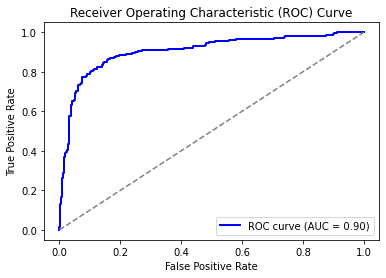

Metrics saved successfully


In [19]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [20]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 30s 853ms/step - loss: 0.1062 - accuracy: 0.9804 - val_loss: 0.3774 - val_accuracy: 0.8571
Epoch 2/150
35/35 [==============================] - 29s 843ms/step - loss: 0.1032 - accuracy: 0.9812 - val_loss: 0.3871 - val_accuracy: 0.8607
Epoch 3/150
35/35 [==============================] - 29s 844ms/step - loss: 0.0919 - accuracy: 0.9848 - val_loss: 0.3804 - val_accuracy: 0.8571
Epoch 4/150
35/35 [==============================] - 29s 845ms/step - loss: 0.0885 - accuracy: 0.9866 - val_loss: 0.3791 - val_accuracy: 0.8750
Epoch 5/150
35/35 [==============================] - 29s 843ms/step - loss: 0.0809 - accuracy: 0.9893 - val_loss: 0.3751 - val_accuracy: 0.8714
Epoch 6/150
35/35 [==============================] - 29s 844ms/step - loss: 0.0851 - accuracy: 0.9839 - val_loss: 0.4074 - val_accuracy: 0.8679
Epoch 7/150
35/35 [==============================] - 29s 845ms/step - loss: 0.1119 - accuracy: 0.9616 - val_loss: 0.4037 - val_accuracy:

19/19 [==============================] - 13s 656ms/step
Inference Time: 12.688477993011475 seconds
9/9 [==============================] - 6s 637ms/step - loss: 0.3751 - accuracy: 0.8714
Validation Loss: 0.3751201033592224
Validation Accuracy: 0.8714285492897034
19/19 [==============================] - 12s 652ms/step - loss: 0.4315 - accuracy: 0.8500
Test Loss: 0.43152451515197754
Test Accuracy: 0.8500000238418579
ROC AUC Score: 0.9036401617849682
Confusion Matrix:
[[254  48]
 [ 42 256]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       302
           1       0.84      0.86      0.85       298

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



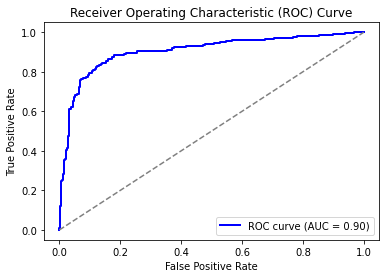

Metrics saved successfully


In [21]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [22]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 30s 849ms/step - loss: 0.0801 - accuracy: 0.9902 - val_loss: 0.3880 - val_accuracy: 0.8607
Epoch 2/200
35/35 [==============================] - 29s 845ms/step - loss: 0.0754 - accuracy: 0.9902 - val_loss: 0.3819 - val_accuracy: 0.8714
Epoch 3/200
35/35 [==============================] - 29s 846ms/step - loss: 0.0691 - accuracy: 0.9920 - val_loss: 0.3975 - val_accuracy: 0.8643
Epoch 4/200
35/35 [==============================] - 29s 845ms/step - loss: 0.0662 - accuracy: 0.9920 - val_loss: 0.4051 - val_accuracy: 0.8679
Epoch 5/200
35/35 [==============================] - 29s 843ms/step - loss: 0.0648 - accuracy: 0.9920 - val_loss: 0.4014 - val_accuracy: 0.8643
Epoch 6/200
35/35 [==============================] - 29s 845ms/step - loss: 0.0589 - accuracy: 0.9929 - val_loss: 0.4025 - val_accuracy: 0.8679
Epoch 7/200
35/35 [==============================] - 29s 847ms/step - loss: 0.0568 - accuracy: 0.9920 - val_loss: 0.4046 - val_accuracy:

19/19 [==============================] - 12s 655ms/step
Inference Time: 12.651602268218994 seconds
9/9 [==============================] - 6s 640ms/step - loss: 0.3819 - accuracy: 0.8714
Validation Loss: 0.38191208243370056
Validation Accuracy: 0.8714285492897034
19/19 [==============================] - 12s 653ms/step - loss: 0.4281 - accuracy: 0.8517
Test Loss: 0.4281236231327057
Test Accuracy: 0.8516666889190674
ROC AUC Score: 0.9068625272234321
Confusion Matrix:
[[258  44]
 [ 45 253]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       302
           1       0.85      0.85      0.85       298

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



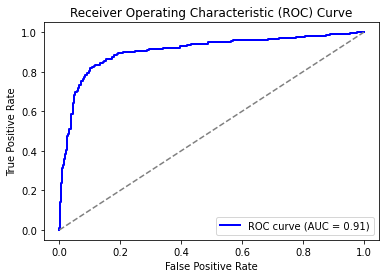

Metrics saved successfully


In [23]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Capsule Network+Dense

In [25]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import cv2
import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Define Capsule Layer
class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, u_vecs):
        u_hat_vecs = tf.reduce_sum(tf.expand_dims(u_vecs, -1) * tf.expand_dims(self.W, 0), axis=-2)
        b = tf.zeros(shape=[tf.shape(u_hat_vecs)[0], self.num_capsule])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s_j = tf.reduce_sum(tf.multiply(c[:, :, None], u_hat_vecs), axis=1)
            v_j = self.squash(s_j)
            if i < self.routings - 1:
                b += tf.reduce_sum(tf.multiply(v_j[:, None, :], u_hat_vecs), axis=-1)
        return v_j

    def squash(self, s_j):
        s_squared_norm = tf.reduce_sum(tf.square(s_j), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s_j


# Start time
start_time = time.time()

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.expand_dims(X_train_resized, axis=-1)  # Add channel dimension
X_train_resized = np.repeat(X_train_resized, 3, axis=-1)  # Repeat the channel dimension to match the expected input shape of ResNet50

# Example: Assuming X_test is another dataset
X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.expand_dims(X_test_resized, axis=-1)
X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Capsule Network
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Reshape((-1, 2048))(x)  # Reshape to 3D tensor for Capsule Network (2048 is the output dimension of ResNet50)
x = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(x)  # Example: 10 capsules with dimension 16
x = Flatten()(x)  # Flatten the output
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Use a single output unit for binary classification

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [26]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 [==============================] - 29s 797ms/step - loss: 0.5957 - accuracy: 0.6866 - val_loss: 0.5271 - val_accuracy: 0.7464
Epoch 2/50
35/35 [==============================] - 28s 812ms/step - loss: 0.4070 - accuracy: 0.8152 - val_loss: 0.4111 - val_accuracy: 0.8214
Epoch 3/50
35/35 [==============================] - 29s 836ms/step - loss: 0.3524 - accuracy: 0.8464 - val_loss: 0.4107 - val_accuracy: 0.8214
Epoch 4/50
35/35 [==============================] - 29s 843ms/step - loss: 0.3171 - accuracy: 0.8616 - val_loss: 0.3878 - val_accuracy: 0.8464
Epoch 5/50
35/35 [==============================] - 29s 837ms/step - loss: 0.2552 - accuracy: 0.8982 - val_loss: 0.4134 - val_accuracy: 0.8393
Epoch 6/50
35/35 [==============================] - 29s 836ms/step - loss: 0.2313 - accuracy: 0.9027 - val_loss: 0.4060 - val_accuracy: 0.8393
Epoch 7/50
35/35 [==============================] - 29s 836ms/step - loss: 0.2388 - accuracy: 0.8955 - val_loss: 0.3993 - val_accuracy: 0.8571

19/19 [==============================] - 13s 652ms/step
Inference Time: 12.92324447631836 seconds
9/9 [==============================] - 6s 640ms/step - loss: 0.3878 - accuracy: 0.8464
Validation Loss: 0.38775864243507385
Validation Accuracy: 0.8464285731315613
19/19 [==============================] - 12s 652ms/step - loss: 0.4065 - accuracy: 0.8200
Test Loss: 0.40654775500297546
Test Accuracy: 0.8199999928474426
ROC AUC Score: 0.9059847104315748
Confusion Matrix:
[[236  66]
 [ 42 256]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       302
           1       0.80      0.86      0.83       298

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600



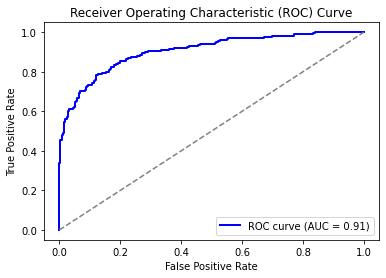

Metrics saved successfully


In [27]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [28]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 [==============================] - 29s 843ms/step - loss: 0.2587 - accuracy: 0.8946 - val_loss: 0.3862 - val_accuracy: 0.8429
Epoch 2/100
35/35 [==============================] - 29s 842ms/step - loss: 0.2322 - accuracy: 0.9098 - val_loss: 0.4373 - val_accuracy: 0.8286
Epoch 3/100
35/35 [==============================] - 29s 839ms/step - loss: 0.2174 - accuracy: 0.9152 - val_loss: 0.3595 - val_accuracy: 0.8679
Epoch 4/100
35/35 [==============================] - 29s 838ms/step - loss: 0.2105 - accuracy: 0.9161 - val_loss: 0.3745 - val_accuracy: 0.8714
Epoch 5/100
35/35 [==============================] - 29s 837ms/step - loss: 0.1726 - accuracy: 0.9250 - val_loss: 0.3685 - val_accuracy: 0.8607
Epoch 6/100
35/35 [==============================] - 29s 837ms/step - loss: 0.1791 - accuracy: 0.9277 - val_loss: 0.4077 - val_accuracy: 0.8571
Epoch 7/100
35/35 [==============================] - 29s 838ms/step - loss: 0.1534 - accuracy: 0.9348 - val_loss: 0.5369 - val_accuracy:

19/19 [==============================] - 12s 653ms/step
Inference Time: 12.61518120765686 seconds
9/9 [==============================] - 6s 644ms/step - loss: 0.3595 - accuracy: 0.8679
Validation Loss: 0.3594529330730438
Validation Accuracy: 0.8678571581840515
19/19 [==============================] - 12s 652ms/step - loss: 0.3880 - accuracy: 0.8333
Test Loss: 0.3879750072956085
Test Accuracy: 0.8333333134651184
ROC AUC Score: 0.9165407351437842
Confusion Matrix:
[[270  32]
 [ 68 230]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       302
           1       0.88      0.77      0.82       298

    accuracy                           0.83       600
   macro avg       0.84      0.83      0.83       600
weighted avg       0.84      0.83      0.83       600



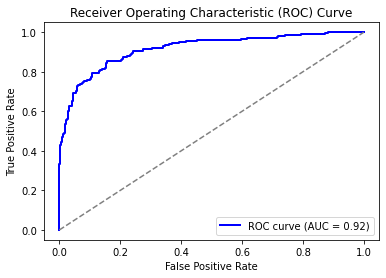

Metrics saved successfully


In [29]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [30]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 [==============================] - 29s 843ms/step - loss: 0.1895 - accuracy: 0.9348 - val_loss: 0.3683 - val_accuracy: 0.8679
Epoch 2/150
35/35 [==============================] - 29s 838ms/step - loss: 0.1505 - accuracy: 0.9411 - val_loss: 0.5913 - val_accuracy: 0.8000
Epoch 3/150
35/35 [==============================] - 29s 841ms/step - loss: 0.1822 - accuracy: 0.9214 - val_loss: 0.4361 - val_accuracy: 0.8250
Epoch 4/150
35/35 [==============================] - 29s 836ms/step - loss: 0.2268 - accuracy: 0.9000 - val_loss: 0.4065 - val_accuracy: 0.8321
Epoch 5/150
35/35 [==============================] - 29s 838ms/step - loss: 0.1657 - accuracy: 0.9259 - val_loss: 0.4599 - val_accuracy: 0.8250
Epoch 6/150
35/35 [==============================] - 29s 839ms/step - loss: 0.1260 - accuracy: 0.9446 - val_loss: 0.4531 - val_accuracy: 0.8536
Training Time: 175.56577348709106 seconds


19/19 [==============================] - 12s 607ms/step
Inference Time: 11.925382852554321 seconds
9/9 [==============================] - 5s 589ms/step - loss: 0.3683 - accuracy: 0.8679
Validation Loss: 0.3683435022830963
Validation Accuracy: 0.8678571581840515
19/19 [==============================] - 12s 619ms/step - loss: 0.4153 - accuracy: 0.8417
Test Loss: 0.4153349697589874
Test Accuracy: 0.8416666388511658
ROC AUC Score: 0.9136183830392461
Confusion Matrix:
[[248  54]
 [ 41 257]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       302
           1       0.83      0.86      0.84       298

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



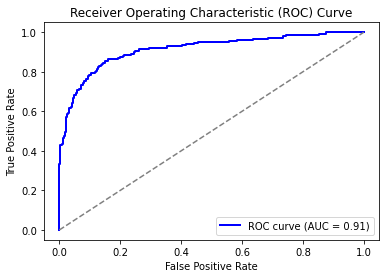

Metrics saved successfully


In [41]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)
# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [42]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 [==============================] - 28s 813ms/step - loss: 0.1647 - accuracy: 0.9321 - val_loss: 0.3566 - val_accuracy: 0.8679
Epoch 2/200
35/35 [==============================] - 28s 814ms/step - loss: 0.1378 - accuracy: 0.9482 - val_loss: 0.4068 - val_accuracy: 0.8679
Epoch 3/200
35/35 [==============================] - 29s 835ms/step - loss: 0.1583 - accuracy: 0.9348 - val_loss: 0.4396 - val_accuracy: 0.8714
Epoch 4/200
35/35 [==============================] - 29s 837ms/step - loss: 0.1451 - accuracy: 0.9429 - val_loss: 0.4217 - val_accuracy: 0.8607
Epoch 5/200
35/35 [==============================] - 29s 838ms/step - loss: 0.1178 - accuracy: 0.9482 - val_loss: 0.4671 - val_accuracy: 0.8643
Epoch 6/200
35/35 [==============================] - 29s 837ms/step - loss: 0.1618 - accuracy: 0.9277 - val_loss: 0.3446 - val_accuracy: 0.8714
Epoch 7/200
35/35 [==============================] - 29s 837ms/step - loss: 0.1457 - accuracy: 0.9411 - val_loss: 0.3991 - val_accuracy:

19/19 [==============================] - 13s 660ms/step
Inference Time: 12.750473260879517 seconds
9/9 [==============================] - 6s 665ms/step - loss: 0.3446 - accuracy: 0.8714
Validation Loss: 0.3446144461631775
Validation Accuracy: 0.8714285492897034
19/19 [==============================] - 13s 659ms/step - loss: 0.3673 - accuracy: 0.8500
Test Loss: 0.36734646558761597
Test Accuracy: 0.8500000238418579
ROC AUC Score: 0.9162296102048979
Confusion Matrix:
[[261  41]
 [ 49 249]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       302
           1       0.86      0.84      0.85       298

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



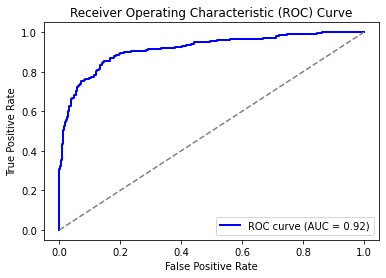

Metrics saved successfully


In [43]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")
